In [339]:
import numpy as np
import random
import pickle
import matplotlib.pyplot as plt
import time

# loading data

In [340]:
# loading training set features
f = open("Datasets/train_set_features.pkl", "rb")
train_set_features2 = pickle.load(f)
f.close()

# reducing feature vector length 
features_STDs = np.std(a=train_set_features2, axis=0)
train_set_features = train_set_features2[:, features_STDs > 52.3]

# changing the range of data between 0 and 1
train_set_features = np.divide(train_set_features, train_set_features.max())

# loading training set labels
f = open("Datasets/train_set_labels.pkl", "rb")
train_set_labels = pickle.load(f)
f.close()

# ------------
# loading test set features
f = open("Datasets/test_set_features.pkl", "rb")
test_set_features2 = pickle.load(f)
f.close()

# reducing feature vector length 
features_STDs = np.std(a=test_set_features2, axis=0)
test_set_features = test_set_features2[:, features_STDs > 48]

# changing the range of data between 0 and 1
test_set_features = np.divide(test_set_features, test_set_features.max())

# loading test set labels
f = open("Datasets/test_set_labels.pkl", "rb")
test_set_labels = pickle.load(f)
f.close()

# ------------
# preparing our training and test sets - joining datasets and labels
train_set = []
test_set = []

for z in range(len(train_set_features)):
    label = np.array([0,0,0,0])
    label[int(train_set_labels[z])] = 1
    label = label.reshape(4,1)
    train_set.append((train_set_features[z].reshape(102,1), label))
    

for z in range(len(test_set_features)):
    label = np.array([0,0,0,0])
    label[int(test_set_labels[z])] = 1
    label = label.reshape(4,1)
    test_set.append((test_set_features[z].reshape(102,1), label))

# shuffle
random.shuffle(train_set)
random.shuffle(test_set)

# print size
print(len(train_set)) #1962
print(len(test_set)) #662

1962
662


# check if images are ok

2


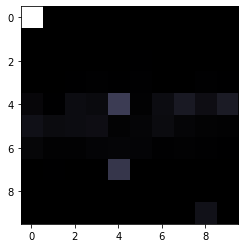

In [341]:
def show_img(img):
    image = np.array(img)
    image.resize((10,10),refcheck=False)
    plt.imshow(image,'bone')
def checking(dataset):
    temp = np.random.randint(0,len(dataset))
    show_img(dataset[temp][0])
    print(np.argmax(dataset[temp][1]))
    plt.show()
checking(train_set)

# activation function and cost function (Mean Squared Error)

In [343]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def sigmoid_derivative(x):
    sig = sigmoid(x)
    return sig * (1 - sig)
def cost_function_mse(train_data, number_of_test, all_weight_input, all_bias_input, last_layer_activation, other_layer_activation):
    temp_cost = 0
    for i in range(number_of_test):
        prediction = forward_propagation(train_data[i][0], all_weight_input, all_bias_input, last_layer_activation, other_layer_activation)
        temp_cost += np.sum(np.square(prediction[-1] - train_data[i][1]))
    return temp_cost / number_of_test
def cost_function_mse_derivative(predict,label_output):
    return 2 * (predict - label_output)

# initial weights and biases (if derivative we just initial them with zero else random number between 0 and 1 )

In [344]:
def initialization(input_model, derivative=False):
    all_weight_init = []
    all_bias_init = []
    if derivative:
        for i in range(len(input_model) - 1):
            temp = np.zeros((input_model[i + 1][0] , input_model[i][0]))
            all_weight_init.append(temp)
    else:
        for i in range(len(input_model) - 1):
            temp = np.random.normal(0, 1, size=(input_model[i + 1][0], input_model[i][0]))
            all_weight_init.append(temp)
    for j in input_model[1:]:
        all_bias_init.append(np.zeros((j[0], 1)))
    return all_weight_init, all_bias_init

# forward propagation and find output of layers

In [345]:
def forward_propagation(image, all_weight_input, all_bias_input, last_layer_activation, other_layer_activation):
    output = [image]
    for i in range(len(all_weight_input)):
        if i == len(all_weight_input) - 1:
            activation = last_layer_activation
        else:
            activation = other_layer_activation
        temp = activation(np.dot(all_weight_input[i], output[i]) + all_bias_input[i])
        output.append(temp)
    return output

# calculate accuracy for specific weights and biases on data set

In [346]:
def accuracy(train_data, number_for_test, all_weight_input, all_bias_input, last_layer_activation, other_layer_activation):
    correct = 0
    for i in range(number_for_test):
        prediction = forward_propagation(train_data[i][0], all_weight_input, all_bias_input, last_layer_activation, other_layer_activation)
        if np.argmax(prediction[-1]) == np.argmax(train_data[i][1]):
            correct += 1
    return correct / number_for_test

# bulid first model without doing any learning

In [347]:
model_first_test = [
    [len(train_set[0][0])],
    [150],
    [60],
    [4],
]
all_weight, all_bias = initialization(model_first_test)
accuracy(train_set, 200, all_weight, all_bias, sigmoid, sigmoid)

0.265

# calculate weight derivative and bias derivative for a layer using for loop

In [348]:
def derivative_with_for_loop(current_layer, previous_layer, d_of_previous_layer, weight, bias, other_layer_derivative):
    row, col = len(weight), len(weight[0])
    derivative_activation = other_layer_derivative
    d_of_cost = np.zeros((col, 1))
    d_of_bias = np.zeros((row, 1))
    d_of_weight = np.zeros((row, col))
    for i in range(row):
        d_of_bias[i] = d_of_previous_layer[i] * derivative_activation(np.dot(weight[i][:], previous_layer) + bias[i])
        for j in range(col):
            d_of_weight[i][j] = d_of_bias[i] * previous_layer[j]
    if current_layer == 0:
        return d_of_weight, d_of_bias, d_of_cost
    for i in range(col):
        for j in range(row):
            d_of_cost[i] += d_of_bias[j] * weight[j][i]
    return d_of_weight, d_of_bias, d_of_cost

# calculate weight derivative and bias derivative for a layer using vectorization

In [349]:
def derivative_with_vectorization(current_layer, previous_layer, d_of_previous_layer, weight, bias, other_layer_derivative):
    row, col = len(weight), len(weight[0])
    derivative_activation = other_layer_derivative
    d_of_cost = np.zeros((col, 1))
    d_of_bias = d_of_previous_layer * derivative_activation(np.dot(weight, previous_layer) + bias)
    d_of_weight = np.dot(d_of_bias, np.transpose(previous_layer))
    if current_layer == 0:
        return d_of_weight, d_of_bias, d_of_cost
    d_of_cost = np.dot(np.transpose(weight), d_of_bias)
    return d_of_weight, d_of_bias, d_of_cost

# calculate back propagation and all weight and bias derivatives

In [350]:
def back_propagation(weights, biases, output_of_layer, label_input, last_layer_derivative, other_layer_derivative, using_vectorization=False):
    all_d_of_weights = []
    all_d_of_biases = []
    all_d_of_costs = [0 for _ in range(len(weights))]
    if last_layer_derivative != softmax_derivative:
        all_d_of_costs[len(weights) - 1] = cost_function_mse_derivative(output_of_layer[-1] ,label_input)
    else:
        all_d_of_costs[len(weights) - 1] = softmax_derivative(output_of_layer[-1] ,label_input)
    for i in range(len(weights) - 1, -1, -1):
        if not using_vectorization:
            temp_weight ,temp_bias ,temp_cost = derivative_with_for_loop(i, output_of_layer[i], all_d_of_costs[i], weights[i], biases[i] ,other_layer_derivative)
        else:
            temp_weight ,temp_bias, temp_cost = derivative_with_vectorization(i ,output_of_layer[i], all_d_of_costs[i] ,weights[i] ,biases[i] ,other_layer_derivative)
        all_d_of_weights.append(temp_weight)
        all_d_of_biases.append(temp_bias)
        all_d_of_costs[i - 1] = temp_cost
    return all_d_of_weights[::-1] ,all_d_of_biases[::-1]


# build main model and giving differnet option to it and start learning

In [351]:
def main_model(model_input, train_data, test_data, learning_rate, epoch, batch, last_layer_activation, other_layer_activation, last_layer_derivative, other_layer_derivative, size_of_using_train_set
               , beta, just_use_train_set=True, use_momentum=False, vectorization=False):
    v = 0
    train_plot = []
    test_plot = []
    cost_plot = []
    all_weights ,all_biases = initialization(model_input)
    if use_momentum:
        v = momentum(model_input)
    for i in range(epoch):
        random.shuffle(train_data)
        random.shuffle(test_data)
        if just_use_train_set:
            train_data = train_data[:size_of_using_train_set]
        list_of_batch = [train_data[j:j + batch] for j in range(0, len(train_data), batch)]
        for each_batch in list_of_batch:
            all_d_of_weights ,all_d_of_biases = initialization(model_input, derivative=True)
            for image , image_label in each_batch:
                output_of_layer = forward_propagation(image, all_weights, all_biases, last_layer_activation, other_layer_activation)
                temp_d_of_weights ,temp_d_of_biases = back_propagation(all_weights, all_biases, output_of_layer, image_label, last_layer_derivative, other_layer_derivative, vectorization)
                for k in range(len(all_d_of_weights)):
                    all_d_of_weights[k] += temp_d_of_weights[k]
                for k in range(len(all_d_of_biases)):
                    all_d_of_biases[k] += temp_d_of_biases[k]
            if not use_momentum:
                for k in range(len(all_weights)):
                    all_weights[k] -= (learning_rate * all_d_of_weights[k]) / batch
                for k in range(len(all_biases)):
                    all_biases[k] -= (learning_rate * all_d_of_biases[k]) / batch
            else:
                for k in range(len(all_weights)):
                    v['dw'][k] = beta * v['dw'][k] + (1 - beta) * all_d_of_weights[k]
                    all_weights[k] -= learning_rate * v['dw'][k] / batch
                for k in range(len(all_biases)):
                    v['db'][k] = beta * v['db'][k] + (1 - beta) * all_d_of_biases[k]
                    all_biases[k] -= learning_rate * v['db'][k] / batch
        train_plot.append(accuracy(train_data, len(train_data), all_weights, all_biases, last_layer_activation, other_layer_activation))
        if last_layer_activation != softmax:
            cost_plot.append(cost_function_mse(train_data, len(train_data), all_weights, all_biases, last_layer_activation, other_layer_activation))
        else:
            cost_plot.append(cross_entropy(train_data, len(train_data), all_weights, all_biases, last_layer_activation, other_layer_activation))
        if not just_use_train_set:
            test_plot.append(accuracy(test_data, len(test_data), all_weights, all_biases, last_layer_activation, other_layer_activation))
            print(f'epoch : {i} ===> cost : {cost_plot[i]} , train accuracy : {train_plot[i]} , test accuracy : {test_plot[i]}')
        else:
            print(f'epoch : {i} ===> cost : {cost_plot[i]} , train accuracy : {train_plot[i]}')
    print('__________________________________________________')
    print(f"train accuracy: {train_plot[-1]}")
    if not just_use_train_set:
        print(f"test accuracy: {test_plot[-1]}")
    else:
        print(f"test accuracy: {cost_plot[-1]}")
    return train_plot ,test_plot ,cost_plot ,all_weights ,all_biases


# show error and accuracy using plot

In [352]:
def show_plot(train_input, test_input, cost_input, just_use_train_set=True):
    plt.plot([i for i in range(1, len(train_input) + 1)], train_input, label='train set accuracy')
    if not just_use_train_set:
         plt.plot([i for i in range(1, len(test_input) + 1)], test_input, label='train set accuracy')
    plt.legend(loc="upper left", frameon=False)
    plt.show()
    plt.plot([i for i in range(1, len(cost_input) + 1)], cost_input, label='cost function')
    plt.legend(loc="upper right", frameon=False)
    plt.show()


# model with 200 image and using for loops

epoch : 0 ===> cost : 1.3881824024870952 , train accuracy : 0.28
epoch : 1 ===> cost : 1.333237512605802 , train accuracy : 0.28
epoch : 2 ===> cost : 1.4352909974706534 , train accuracy : 0.28
epoch : 3 ===> cost : 0.9737614843153837 , train accuracy : 0.545
epoch : 4 ===> cost : 0.457926631574977 , train accuracy : 0.655
epoch : 5 ===> cost : 0.5017556661671487 , train accuracy : 0.515
epoch : 6 ===> cost : 0.24782207753773286 , train accuracy : 0.795
epoch : 7 ===> cost : 0.2431727403505567 , train accuracy : 0.795
epoch : 8 ===> cost : 0.29400201994336916 , train accuracy : 0.79
epoch : 9 ===> cost : 0.21882988209145918 , train accuracy : 0.795
__________________________________________________
train accuracy: 0.795
test accuracy: 0.21882988209145918


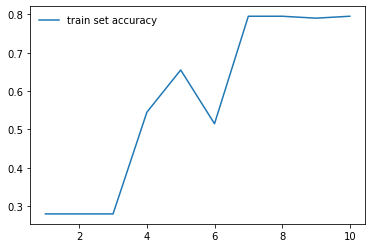

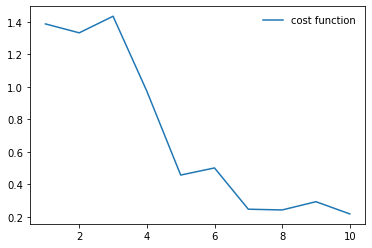

minutes : 3
seconds : 8


In [355]:
start_time = time.time()
train ,test ,cost ,final_weights ,final_biases = main_model(model_first_test ,train_set ,test_set ,1 ,10 ,10 ,sigmoid ,sigmoid ,sigmoid_derivative ,sigmoid_derivative ,200 ,0.7 ,just_use_train_set=True ,use_momentum=False ,vectorization=False)
show_plot(train ,test ,cost ,just_use_train_set=True)
final_time_second = round(time.time() - start_time)
print(f"minutes : {final_time_second // 60}")
print(f"seconds : {final_time_second % 60}")

round : 1
epoch : 0 ===> cost : 0.10047390449300231 , train accuracy : 0.9943934760448522 , test accuracy : 0.9259818731117825
epoch : 1 ===> cost : 0.010075607033534394 , train accuracy : 1.0 , test accuracy : 0.9335347432024169
epoch : 2 ===> cost : 0.004981890761738298 , train accuracy : 1.0 , test accuracy : 0.9607250755287009
epoch : 3 ===> cost : 0.002734160393280023 , train accuracy : 1.0 , test accuracy : 0.9954682779456193
epoch : 4 ===> cost : 0.0019855961048076665 , train accuracy : 1.0 , test accuracy : 0.9909365558912386
__________________________________________________
train accuracy: 1.0
test accuracy: 0.9909365558912386
min 0.0 : sec 4.388
____________________________________________________________________________________________________
round : 2
epoch : 0 ===> cost : 0.26682806237788875 , train accuracy : 0.7502548419979612 , test accuracy : 0.7492447129909365
epoch : 1 ===> cost : 0.25166405962688165 , train accuracy : 0.7502548419979612 , test accuracy : 0.7492447

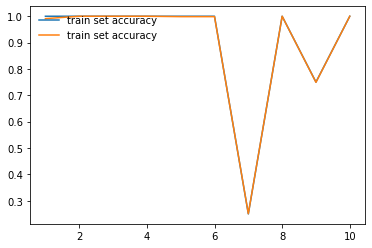

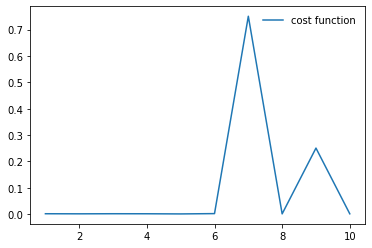

average cost : 0.10157181767365135 and average accuracy on train set : 0.9 and average accuracy on test set : 0.8987915407854985


In [356]:
train_rounds = []
test_rounds = []
cost_rounds = []
for i in range(10):
    print(f"round : {i + 1}")
    start = time.time()
    train ,test ,cost ,final_weights ,final_biases = main_model(model_first_test ,train_set ,test_set ,1 ,5 ,10 ,sigmoid ,sigmoid ,sigmoid_derivative ,sigmoid_derivative ,200 ,0.9,just_use_train_set=False ,vectorization=True)
    end = round(time.time() - start , 3)
    print('min {} : sec {}'.format(end//60 , end % 60))
    train_rounds.append(train[-1])
    test_rounds.append(test[-1])
    cost_rounds.append(cost[-1])
    print("____________________________________________________________________________________________________")
show_plot(train_rounds ,test_rounds ,cost_rounds ,just_use_train_set=False)
print(f"average cost : {sum(cost_rounds) / 10} and average accuracy on train set : {sum(train_rounds) / 10} and average accuracy on test set : {sum(test_rounds) / 10}")

# test calculated weights and biases for prediction and print results

In [357]:
def test_prediction(test_set_input, all_weight_input, all_bias_input, last_layer_activation, other_layer_activation):
    fruits = ["apple","lemon","mango","raspberry"]
    rand = random.randint(0, len(test_set_input))
    prediction = forward_propagation(test_set_input[rand][0], all_weight_input, all_bias_input, last_layer_activation, other_layer_activation)
    prediction_label = prediction[-1]
    image_label = np.where(test_set_input[rand][1] == np.amax(test_set_input[rand][1]))
    prediction_image = np.where(prediction_label == np.amax(prediction_label))
    print(f"image was a {fruits[int(image_label[0])]}")
    print(f"and the prediction was a {fruits[int(prediction_image[0])]}")

In [360]:
test_prediction(test_set, final_weights ,final_biases ,sigmoid ,sigmoid)

image was a mango
and the prediction was a mango


# extra credit 1 (finding good learning rate and batch and epoch)

epoch : 0 ===> cost : 1.357421140558501 , train accuracy : 0.25
epoch : 1 ===> cost : 1.2961207453754826 , train accuracy : 0.25
epoch : 2 ===> cost : 1.290069326819384 , train accuracy : 0.25
epoch : 3 ===> cost : 1.109412039238694 , train accuracy : 0.25
epoch : 4 ===> cost : 1.0793055376347798 , train accuracy : 0.25
__________________________________________________
train accuracy: 0.25
test accuracy: 1.0793055376347798


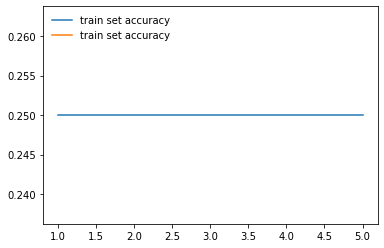

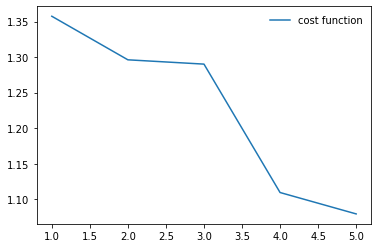

minutes : 0
seconds : 1


In [361]:
#learning rate = 1 ,epoch = 5 and batch = 10 for still 200 images
start_time = time.time()
train ,test ,cost ,final_weights ,final_biases = main_model(model_first_test ,train_set ,test_set ,1 ,5 ,10 ,sigmoid ,sigmoid ,sigmoid_derivative ,sigmoid_derivative ,200 ,0.7 ,just_use_train_set=True ,use_momentum=True ,vectorization=True)
show_plot(train ,test ,cost ,just_use_train_set=False)
final_time_second = round(time.time() - start_time)
print(f"minutes : {final_time_second // 60}")
print(f"seconds : {final_time_second % 60}")

epoch : 0 ======> cost : 0.598719083833945 , train accuracy : 0.61
epoch : 1 ======> cost : 0.4039078872658318 , train accuracy : 0.75
epoch : 2 ======> cost : 0.32805750836973785 , train accuracy : 0.755
epoch : 3 ======> cost : 0.29938027027764724 , train accuracy : 0.75
epoch : 4 ======> cost : 0.2823951418477812 , train accuracy : 0.755
__________________________________________________
train accuracy: 0.755
test accuracy: 0.2823951418477812


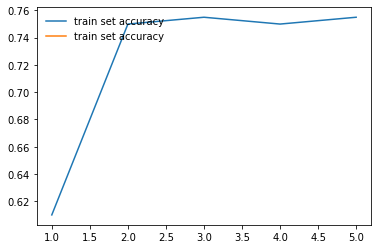

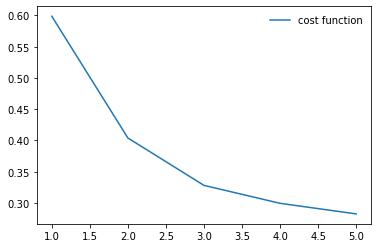

minutes : 0
seconds : 1


In [283]:
#learning rate = 0.5 ,epoch = 5 and batch = 10 for still 200 images
start_time = time.time()
train ,test ,cost ,final_weights ,final_biases = main_model(model_first_test ,train_set ,test_set ,0.5 ,5 ,10 ,sigmoid ,sigmoid ,sigmoid_derivative ,sigmoid_derivative ,200 ,0.7 ,just_use_train_set=True ,use_momentum=True ,vectorization=True)
show_plot(train ,test ,cost ,just_use_train_set=False)
final_time_second = round(time.time() - start_time)
print(f"minutes : {final_time_second // 60}")
print(f"seconds : {final_time_second % 60}")

epoch : 0 ======> cost : 0.49747043733618895 , train accuracy : 0.655
epoch : 1 ======> cost : 0.38874842017983446 , train accuracy : 0.68
epoch : 2 ======> cost : 0.19501436331763272 , train accuracy : 0.98
epoch : 3 ======> cost : 0.08100252736321105 , train accuracy : 0.99
epoch : 4 ======> cost : 0.09750092308659397 , train accuracy : 0.96
epoch : 5 ======> cost : 0.05082372832896902 , train accuracy : 1.0
epoch : 6 ======> cost : 0.04288764324458512 , train accuracy : 0.995
epoch : 7 ======> cost : 0.03273424451699296 , train accuracy : 1.0
epoch : 8 ======> cost : 0.028518705584547544 , train accuracy : 1.0
epoch : 9 ======> cost : 0.03011759399719186 , train accuracy : 0.985
__________________________________________________
train accuracy: 0.985
test accuracy: 0.03011759399719186


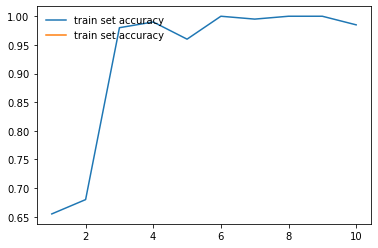

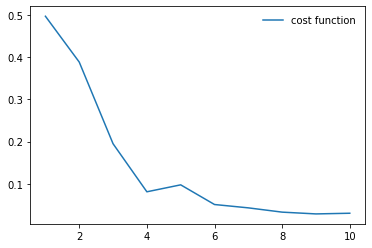

minutes : 0
seconds : 1


In [286]:
#learning rate = 0.5 ,epoch = 10 and batch = 10 for still 200 images
start_time = time.time()
train ,test ,cost ,final_weights ,final_biases = main_model(model_first_test ,train_set ,test_set ,0.5 ,10 ,10 ,sigmoid ,sigmoid ,sigmoid_derivative ,sigmoid_derivative ,200 ,0.7 ,just_use_train_set=True ,use_momentum=True ,vectorization=True)
show_plot(train ,test ,cost ,just_use_train_set=False)
final_time_second = round(time.time() - start_time)
print(f"minutes : {final_time_second // 60}")
print(f"seconds : {final_time_second % 60}")

epoch : 0 ===> cost : 0.6879565864560662 , train accuracy : 0.48
epoch : 1 ===> cost : 0.5186083004049381 , train accuracy : 0.68
epoch : 2 ===> cost : 0.4529400214507032 , train accuracy : 0.715
epoch : 3 ===> cost : 0.41538497956347803 , train accuracy : 0.69
epoch : 4 ===> cost : 0.37884223103609055 , train accuracy : 0.72
__________________________________________________
train accuracy: 0.72
test accuracy: 0.37884223103609055


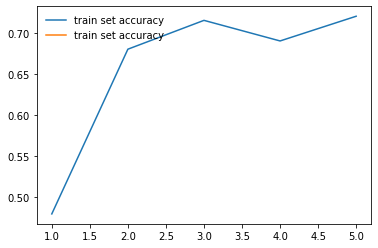

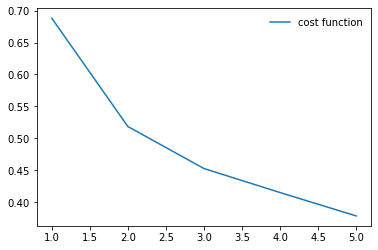

minutes : 0
seconds : 1


In [362]:
#learning rate = 0.5 ,epoch = 10 and batch = 20 for still 200 images
start_time = time.time()
train ,test ,cost ,final_weights ,final_biases = main_model(model_first_test ,train_set ,test_set ,0.5 ,5 ,20 ,sigmoid ,sigmoid ,sigmoid_derivative ,sigmoid_derivative ,200 ,0.7 ,just_use_train_set=True ,use_momentum=True ,vectorization=True)
show_plot(train ,test ,cost ,just_use_train_set=False)
final_time_second = round(time.time() - start_time)
print(f"minutes : {final_time_second // 60}")
print(f"seconds : {final_time_second % 60}")

# extra credit 2 (improve SGD by using momentum)

In [ ]:
def momentum(model):
    dimensions = [(model[i+1][0], model[i][0]) for i in range(len(model)-1)]
    v = {'dw':[],'db':[]}
    for dimension in dimensions:
        d_of_weight = np.zeros(dimension)
        d_of_bias = np.zeros((dimension[0] ,1))
        v['dw'].append(d_of_weight)
        v['db'].append(d_of_bias)
    return v

epoch : 0 ======> cost : 1.3098026532322349 , train accuracy : 0.222
epoch : 1 ======> cost : 0.8118532295828631 , train accuracy : 0.222
epoch : 2 ======> cost : 0.7881153822047359 , train accuracy : 0.222
epoch : 3 ======> cost : 0.7847108745212521 , train accuracy : 0.222
epoch : 4 ======> cost : 0.7827096512164434 , train accuracy : 0.222
__________________________________________________
train accuracy: 0.222
test accuracy: 0.7827096512164434


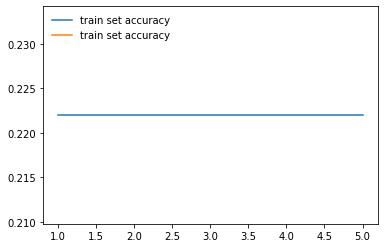

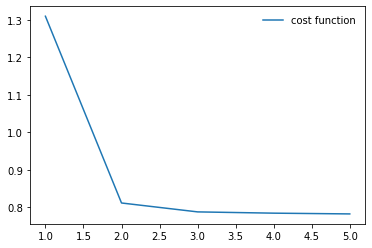

minutes : 0
seconds : 1


In [290]:
# without using momentum on 500 images
start_time = time.time()
train ,test ,cost ,final_weights ,final_biases = main_model(model_first_test ,train_set ,test_set ,1 ,5 ,10 ,sigmoid ,sigmoid ,sigmoid_derivative ,sigmoid_derivative ,500 ,0.7 ,just_use_train_set=True ,use_momentum=False ,vectorization=True)
show_plot(train ,test ,cost ,just_use_train_set=False)
final_time_second = round(time.time() - start_time)
print(f"minutes : {final_time_second // 60}")
print(f"seconds : {final_time_second % 60}")

epoch : 0 ======> cost : 0.6716138880739869 , train accuracy : 0.492
epoch : 1 ======> cost : 0.44831913591013434 , train accuracy : 0.732
epoch : 2 ======> cost : 0.28932586468776994 , train accuracy : 0.732
epoch : 3 ======> cost : 0.28081418839095923 , train accuracy : 0.732
epoch : 4 ======> cost : 0.27727751179413707 , train accuracy : 0.732
__________________________________________________
train accuracy: 0.732
test accuracy: 0.27727751179413707


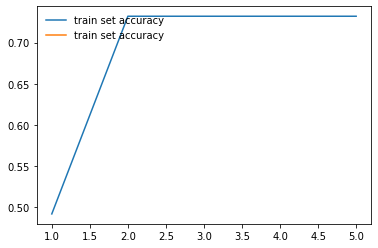

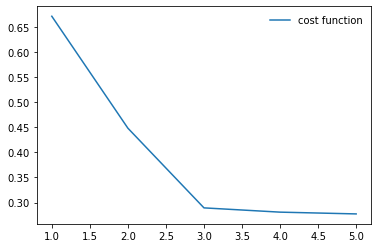

minutes : 0
seconds : 1


In [291]:
#using momentum on 500 image
start_time = time.time()
train ,test ,cost ,final_weights ,final_biases = main_model(model_first_test ,train_set ,test_set ,1 ,5 ,10 ,sigmoid ,sigmoid ,sigmoid_derivative ,sigmoid_derivative ,500 ,0.7 ,just_use_train_set=True ,use_momentum=True ,vectorization=True)
show_plot(train ,test ,cost ,just_use_train_set=False)
final_time_second = round(time.time() - start_time)
print(f"minutes : {final_time_second // 60}")
print(f"seconds : {final_time_second % 60}")

# extra credit 3 (adding a new fruit)

In [298]:
import os
import skimage.io, skimage.color, skimage.feature

In [299]:
fruits = ["apple", "lemon", "mango", "raspberry" ,"banana"]
#492+490+490+490+490+427=2,452
dataset_features = np.zeros(shape=(2452, 360))
outputs = np.zeros(shape=(2452))

idx = 0
class_label = 0
for fruit_dir in fruits:
    curr_dir = os.path.join(os.path.sep + "datasets/Fruits-360/Train", fruit_dir)
    all_imgs = os.listdir(os.getcwd()+curr_dir)
    for img_file in all_imgs:
        if img_file.endswith(".jpg"): # Ensures reading only JPG files.
            fruit_data = skimage.io.imread(fname=os.path.sep.join([os.getcwd(), curr_dir, img_file]), as_gray=False)
            fruit_data_hsv = skimage.color.rgb2hsv(rgb=fruit_data)
            hist = np.histogram(a=fruit_data_hsv[:, :, 0], bins=360)
            dataset_features[idx, :] = hist[0]
            outputs[idx] = class_label
            idx = idx + 1
    class_label = class_label + 1

with open("datasets/train_set_features2.pkl", "wb") as f:
    pickle.dump(dataset_features, f)

with open("datasets/train_set_labels2.pkl", "wb") as f:
    pickle.dump(outputs, f)

In [300]:
#164+166+166+166+166=828
dataset_features = np.zeros(shape=(828, 360))
outputs = np.zeros(shape=(828))

idx = 0
class_label = 0
for fruit_dir in fruits:
    curr_dir = os.path.join(os.path.sep + "datasets/Fruits-360/Test", fruit_dir)
    all_imgs = os.listdir(os.getcwd()+curr_dir)
    for img_file in all_imgs:
        if img_file.endswith(".jpg"): # Ensures reading only JPG files.
            fruit_data = skimage.io.imread(fname=os.path.sep.join([os.getcwd(), curr_dir , img_file]), as_gray=False)
            fruit_data_hsv = skimage.color.rgb2hsv(rgb=fruit_data)
            hist = np.histogram(a=fruit_data_hsv[:, :, 0], bins=360)
            dataset_features[idx, :] = hist[0]
            outputs[idx] = class_label
            idx = idx + 1
    class_label = class_label + 1

with open("datasets/test_set_features2.pkl", "wb") as f:
    pickle.dump(dataset_features, f)

with open("datasets/test_set_labels2.pkl", "wb") as f:
    pickle.dump(outputs, f)

In [302]:
# loading new training set features
f = open("datasets/train_set_features2.pkl", "rb")
train_set_features2 = pickle.load(f)
f.close()

# reducing feature vector length
features_STDs = np.std(a=train_set_features2, axis=0)
train_set_features = train_set_features2[:, features_STDs > 52.3]

# changing the range of data between 0 and 1
train_set_features = np.divide(train_set_features, train_set_features.max())

# loading training set labels
f = open("datasets/train_set_labels2.pkl", "rb")
train_set_labels = pickle.load(f)
f.close()

# ------------
# loading test set features
f = open("Datasets/test_set_features2.pkl", "rb")
test_set_features2 = pickle.load(f)
f.close()

# reducing feature vector length
features_STDs = np.std(a=test_set_features2, axis=0)
test_set_features = test_set_features2[:, features_STDs > 48]

# changing the range of data between 0 and 1
test_set_features = np.divide(test_set_features, test_set_features.max())

# loading test set labels
f = open("Datasets/test_set_labels2.pkl", "rb")
test_set_labels = pickle.load(f)
f.close()

# ------------
# preparing our training and test sets - joining datasets and lables
train_set_second = []
test_set_second = []

for i in range(len(train_set_features)):
    label = np.array([0,0,0,0,0])
    label[int(train_set_labels[i])] = 1
    label = label.reshape(5,1)
    train_set_second.append((train_set_features[i].reshape(104,1), label))


for i in range(len(test_set_features)):
    label = np.array([0,0,0,0,0])
    label[int(test_set_labels[i])] = 1
    label = label.reshape(5,1)
    test_set_second.append((test_set_features[i].reshape(104,1), label))

# shuffle
random.shuffle(train_set_second)
random.shuffle(test_set_second)

# print size
print(len(train_set_second)) #2452
print(len(test_set_second)) #828

2452
828


In [304]:
model_second_test = [
    [len(train_set_second[0][0])],
    [180],
    [70],
    [5],
]
all_weight, all_bias = initialization(model_second_test)
accuracy(train_set_second, 200, all_weight, all_bias, sigmoid, sigmoid)

0.17

epoch : 0 ======> cost : 0.7959586664745283 , train accuracy : 0.32830342577487764 , test accuracy : 0.29589371980676327
epoch : 1 ======> cost : 0.6690696962984526 , train accuracy : 0.7259380097879282 , test accuracy : 0.5845410628019324
epoch : 2 ======> cost : 0.6228336962268635 , train accuracy : 0.399673735725938 , test accuracy : 0.40096618357487923
epoch : 3 ======> cost : 0.40076713307247996 , train accuracy : 0.6676182707993474 , test accuracy : 0.6014492753623188
epoch : 4 ======> cost : 0.05258739801906805 , train accuracy : 0.9637030995106036 , test accuracy : 0.9154589371980676
epoch : 5 ======> cost : 0.01514803968297868 , train accuracy : 0.9906199021207178 , test accuracy : 1.0
epoch : 6 ======> cost : 0.007699508850790428 , train accuracy : 0.99836867862969 , test accuracy : 0.9939613526570048
epoch : 7 ======> cost : 0.003593829126222111 , train accuracy : 0.9995921696574225 , test accuracy : 0.998792270531401
epoch : 8 ======> cost : 0.011661488966548198 , train acc

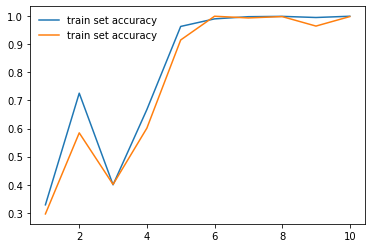

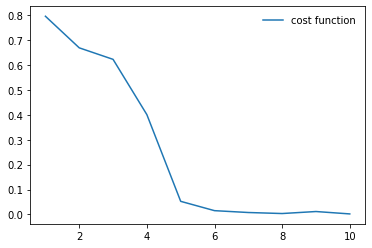

minutes : 0
seconds : 18


In [307]:
start_time = time.time()
train ,test ,cost ,final_weights ,final_biases = main_model(model_second_test ,train_set_second ,test_set_second ,1 ,10 ,10 ,sigmoid ,sigmoid ,sigmoid_derivative ,sigmoid_derivative ,200 ,0.7 ,just_use_train_set=False ,use_momentum=False ,vectorization=True)
show_plot(train ,test ,cost ,just_use_train_set=False)
final_time_second = round(time.time() - start_time)
print(f"minutes : {final_time_second // 60}")
print(f"seconds : {final_time_second % 60}")

# extra credit 4 (using softmax for output)

In [327]:
def softmax(x):
    e = np.exp(x)
    return e / np.sum(e)
def softmax_derivative(predict ,label_output):
    return predict - label_output
def cross_entropy(train_data, number_of_test, all_weight_input, all_bias_input, last_layer_activation, other_layer_activation):
    temp_cost = 0
    for i in range(number_of_test):
        predictions = forward_propagation(train_data[i][0], all_weight_input, all_bias_input, last_layer_activation, other_layer_activation)
        prediction = predictions[-1]
        temp_cost += np.sum([-y * np.log(x) for x, y in zip(prediction, train_data[i][1])]) / len(prediction)
    return temp_cost / number_of_test

epoch : 0 ======> cost : 0.25889764331511395 , train accuracy : 0.881
epoch : 1 ======> cost : 0.024829517754704496 , train accuracy : 1.0
epoch : 2 ======> cost : 0.017011454516801548 , train accuracy : 1.0
epoch : 3 ======> cost : 0.011461480794983913 , train accuracy : 1.0
epoch : 4 ======> cost : 0.008367742953530544 , train accuracy : 1.0
epoch : 5 ======> cost : 0.0074906903189010275 , train accuracy : 1.0
epoch : 6 ======> cost : 0.006871485201130225 , train accuracy : 1.0
epoch : 7 ======> cost : 0.005562712559297925 , train accuracy : 1.0
epoch : 8 ======> cost : 0.004827819522906126 , train accuracy : 1.0
epoch : 9 ======> cost : 0.0037936795561228525 , train accuracy : 1.0
__________________________________________________
train accuracy: 1.0
test accuracy: 0.0037936795561228525


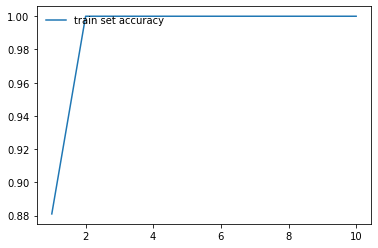

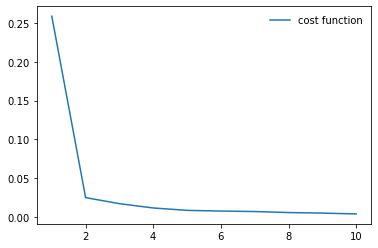

minutes : 0
seconds : 7


In [336]:
#without using softmax on 1000 image
start_time = time.time()
train ,test ,cost ,final_weights ,final_biases = main_model(model_first_test ,train_set ,test_set ,0.5 ,10 ,10 ,sigmoid ,sigmoid ,sigmoid_derivative ,sigmoid_derivative ,1000 ,0.7 ,just_use_train_set=True ,use_momentum=False ,vectorization=True)
show_plot(train ,test ,cost ,just_use_train_set=True)
final_time_second = round(time.time() - start_time)
print(f"minutes : {final_time_second // 60}")
print(f"seconds : {final_time_second % 60}")

epoch : 0 ======> cost : 1.0613219845873685 , train accuracy : 0.407
epoch : 1 ======> cost : 0.9028927083963428 , train accuracy : 0.522
epoch : 2 ======> cost : 0.2767014217785198 , train accuracy : 0.765
epoch : 3 ======> cost : 0.1623811504952393 , train accuracy : 0.765
epoch : 4 ======> cost : 0.03480735660723655 , train accuracy : 0.993
epoch : 5 ======> cost : 0.019546235031027683 , train accuracy : 0.999
epoch : 6 ======> cost : 0.013852534719046568 , train accuracy : 0.999
epoch : 7 ======> cost : 0.01106703730462228 , train accuracy : 1.0
epoch : 8 ======> cost : 0.009251897994795266 , train accuracy : 0.999
epoch : 9 ======> cost : 0.008030639068593458 , train accuracy : 0.999
__________________________________________________
train accuracy: 0.999
test accuracy: 0.008030639068593458


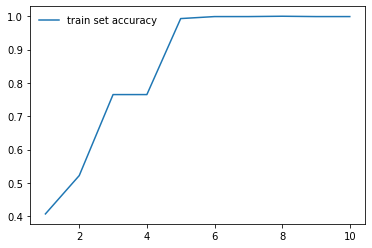

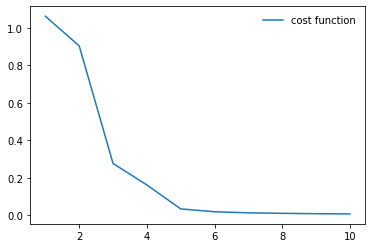

minutes : 0
seconds : 7


In [337]:
#using softmax on 1000 image
start_time = time.time()
train ,test ,cost ,final_weights ,final_biases = main_model(model_first_test ,train_set ,test_set ,0.5 ,10 ,10 ,softmax ,sigmoid ,softmax_derivative ,sigmoid_derivative ,1000 ,0.7 ,just_use_train_set=True ,use_momentum=False ,vectorization=True)
show_plot(train ,test ,cost ,just_use_train_set=True)
final_time_second = round(time.time() - start_time)
print(f"minutes : {final_time_second // 60}")
print(f"seconds : {final_time_second % 60}")